# Cross-validation lung data
Does five-fold crossvalidation in annotating lung data to get stability of different algorithms

In [1]:
import os, sys

import popv
import anndata
import numpy as np
import scanpy as sc
from scanpy.plotting import palettes
import sys
sys.path.insert(-1, '..')
import _utils

From /home/cane/miniconda3/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:107: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term
Created a temporary directory at /tmp/tmpx5rrngus
Writing /tmp/tmpx5rrngus/_remote_module_non_scriptable.py
Global seed set to 0


## Run PopV

In [2]:
refdata_url = '"https://zenodo.org/record/7587774/files/TS_Lymph_Node_filtered.h5ad?download"'
ln_fn = 'data/Lymph_Node.h5ad'
if not os.path.exists(ln_fn):
    !wget -O $ln_fn $refdata_url

ln = anndata.read(ln_fn)

In [3]:
ln

AnnData object with n_obs × n_vars = 43502 × 58559
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay'
    var: 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'

In [4]:
2

2

In [5]:
query_index = np.random.choice([0,1,2,3,4], size = len(ln), replace=True)

In [6]:
if not os.path.exists('data'):
    os.mkdir('data')

In [7]:
for i in range(0,5):
    ref_adata_path = "data/ref_{}.h5ad".format(i)
    query_adata_path = "data/query_{}.h5ad".format(i)
    ln[query_index!=i].write(ref_adata_path)
    ln[query_index==i].write(query_adata_path)

In [8]:
save_folder = 'popv_results'
query_batch_key = 'donor_assay'

# Lesser used parameters
query_labels_key=None
unknown_celltype_label='unknown'

# Following parameters are specific to Tabula Sapiens dataset
ref_labels_key='cell_ontology_class'
ref_batch_key = 'donor_assay'

In [9]:
from popv.preprocessing import Process_Query
from popv.annotation import annotate_data

In [10]:
for i in range(5):
    print(i)
    save_folder = f'cv_run_{i}/popv_results_{i}'
    if not os.path.exists(f'cv_run_{i}'):
        os.mkdir(f'cv_run_{i}')
    
    ref_adata_path = "data/ref_{}.h5ad".format(i)
    query_adata_path = "data/query_{}.h5ad".format(i)
    
    # read in the reference dataset
    ref_adata = anndata.read(ref_adata_path)
    query_adata = anndata.read(query_adata_path)
    
    min_celltype_size = np.min(ref_adata.obs.groupby('cell_ontology_class').size())
    n_samples_per_label = np.max((min_celltype_size, 100))
    
    adata = Process_Query(
        query_adata,
        ref_adata,
        query_labels_key=query_labels_key,
        query_batch_key=query_batch_key,
        ref_labels_key=ref_labels_key,
        ref_batch_key=ref_batch_key,
        unknown_celltype_label=unknown_celltype_label,
        save_path_trained_models=f'cv_run_{i}/pretrained_models/',
        cl_obo_folder='../PopV/ontology/',
        prediction_mode='retrain',
        n_samples_per_label=n_samples_per_label,
        use_gpu=True,
        compute_embedding=True,
        hvg=4000
    ).adata
    
    annotate_data(adata, save_path=save_folder)
    adata.write(f'cv_run_{i}/annotated_query.h5ad')

0


Sampling 100 per label
Saving celltypist results to adata.obs["popv_celltypist_prediction"]
🍳 Preparing data before training
✂️ 45 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 43502 cells and 4000 genes
🔗 Matching reference genes in the model
🧬 3955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!
Integrating data with bbknn
Saving knn on bbknn results to adata.obs["popv_knn_on_bbknn_prediction"]
Saving UMAP of bbknn results to adata.obs["X_bbknn_umap_popv"]
Integrating data with scanorama


Found 4000 genes among all datasets
[[0.         0.98665011 0.22610392 0.0516992  0.49753229 0.30292887
  0.13163482 0.04090909]
 [0.         0.         0.31605092 0.02603037 0.57031978 0.18410042
  0.08492569 0.02272727]
 [0.         0.         0.         0.99023861 0.06164024 0.03138075
  0.36518047 0.13181818]
 [0.         0.         0.         0.         0.14244396 0.01966527
  0.47770701 0.11818182]
 [0.         0.         0.         0.         0.         0.98912134
  0.4044586  0.16363636]
 [0.         0.         0.         0.         0.         0.
  0.34501062 0.05909091]
 [0.         0.         0.         0.         0.         0.
  0.         0.97727273]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]
Processing datasets (2, 3)
Processing datasets (4, 5)
Processing datasets (0, 1)
Processing datasets (6, 7)
Processing datasets (1, 4)
Processing datasets (0, 4)
Processing datasets (3, 6)
Processing datasets (4, 6)
Processing datasets (2, 6)


Saving knn on scanorama results to adata.obs["popv_knn_on_scanorama_prediction"]
Saving UMAP of scanorama results to adata.obs["X_umap_scanorma_popv"]
Integrating data with scvi
Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Training scvi offline.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Epoch 92/92: 100%|██████████| 92/92 [02:24<00:00,  1.51s/it, loss=1.15e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=92` reached.


Epoch 92/92: 100%|██████████| 92/92 [02:24<00:00,  1.57s/it, loss=1.15e+03, v_num=1]


Saving knn on scvi results to adata.obs["popv_knn_on_scvi_prediction"]
Saving UMAP of scvi results to adata.obs["X_scvi_umap_popv"]
Computing Onclass. Storing prediction in adata.obs["popv_onclass_prediction"]


Training cost after epoch 1: loss:5.660962 acc: 0.874 auc: 0.999 auprc: 0.916
Training cost after epoch 2: loss:2.902212 acc: 0.934 auc: 1.000 auprc: 0.977
Training cost after epoch 3: loss:2.072257 acc: 0.963 auc: 1.000 auprc: 1.000
Training cost after epoch 4: loss:1.596666 acc: 0.982 auc: 1.000 auprc: 1.000
Training cost after epoch 5: loss:1.263015 acc: 0.986 auc: 1.000 auprc: 1.000
Training cost after epoch 6: loss:1.012669 acc: 0.996 auc: 1.000 auprc: 1.000
Training cost after epoch 7: loss:0.824663 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 8: loss:0.677063 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 9: loss:0.563566 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 10: loss:0.476884 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 11: loss:0.411376 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 12: loss:0.361224 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 13: loss:0.322396 acc: 0.998 auc: 1

Computing random forest classifier. Storing prediction in adata.obs["popv_rf_prediction"]
Integrating data with scANVI


INFO     File cv_run_0/pretrained_models//scvi/model.pt already downloaded                                         
INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it, loss=1.25e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it, loss=1.25e+03, v_num=1]

Saving scanvi label prediction to adata.obs["popv_scanvi_prediction"]


Saving UMAP of scanvi results to adata.obs["X_scanvi_umap_popv"]
Computing support vector machine. Storing prediction in adata.obs["popv_svm_prediction"]
Using predictions ['popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction'] for PopV consensus
Predictions saved to cv_run_0/popv_results_0/predictions.csv
... storing '_batch_annotation' as categorical
... storing '_labels_annotation' as categorical
... storing 'popv_knn_on_bbknn_prediction' as categorical
... storing 'popv_knn_on_scanorama_prediction' as categorical
... storing 'popv_knn_on_scvi_prediction' as categorical
... storing '_labels_annotation_cell_ontology_id' as categorical
... storing 'popv_onclass_prediction' as categorical
... storing 'popv_onclass_seen' as categorical
... storing 'popv_rf_prediction' as categorical
... storing 'popv_scanvi_prediction

1


Sampling 100 per label
Saving celltypist results to adata.obs["popv_celltypist_prediction"]
🍳 Preparing data before training
✂️ 51 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 43502 cells and 4000 genes
🔗 Matching reference genes in the model
🧬 3949 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!
Integrating data with bbknn
Saving knn on bbknn results to adata.obs["popv_knn_on_bbknn_prediction"]
Saving UMAP of bbknn results to adata.obs["X_bbknn_umap_popv"]
Integrating data with scanorama


Found 4000 genes among all datasets
[[0.         0.9876161  0.22451876 0.0371707  0.50606604 0.29704191
  0.13746065 0.04784689]
 [0.         0.         0.32383901 0.01840491 0.57647059 0.173788
  0.0587618  0.01435407]
 [0.         0.         0.         0.98845182 0.05591307 0.02670501
  0.39979014 0.16267943]
 [0.         0.         0.         0.         0.11115121 0.01768315
  0.40818468 0.16267943]
 [0.         0.         0.         0.         0.         0.98972884
  0.37040923 0.11483254]
 [0.         0.         0.         0.         0.         0.
  0.35257083 0.09569378]
 [0.         0.         0.         0.         0.         0.
  0.         0.99521531]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]
Processing datasets (6, 7)
Processing datasets (4, 5)
Processing datasets (2, 3)
Processing datasets (0, 1)
Processing datasets (1, 4)
Processing datasets (0, 4)
Processing datasets (3, 6)
Processing datasets (2, 6)
Processing datasets (4, 6)
Pr

Saving knn on scanorama results to adata.obs["popv_knn_on_scanorama_prediction"]
Saving UMAP of scanorama results to adata.obs["X_umap_scanorma_popv"]
Integrating data with scvi
Training scvi offline.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 92/92: 100%|██████████| 92/92 [02:25<00:00,  1.56s/it, loss=1.15e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=92` reached.


Epoch 92/92: 100%|██████████| 92/92 [02:25<00:00,  1.58s/it, loss=1.15e+03, v_num=1]


Saving knn on scvi results to adata.obs["popv_knn_on_scvi_prediction"]
Saving UMAP of scvi results to adata.obs["X_scvi_umap_popv"]
Computing Onclass. Storing prediction in adata.obs["popv_onclass_prediction"]


Training cost after epoch 1: loss:5.628715 acc: 0.864 auc: 0.998 auprc: 0.918
Training cost after epoch 2: loss:2.866293 acc: 0.929 auc: 1.000 auprc: 0.973
Training cost after epoch 3: loss:2.042398 acc: 0.966 auc: 1.000 auprc: 0.999
Training cost after epoch 4: loss:1.570226 acc: 0.985 auc: 1.000 auprc: 1.000
Training cost after epoch 5: loss:1.238354 acc: 0.991 auc: 1.000 auprc: 1.000
Training cost after epoch 6: loss:0.995510 acc: 0.997 auc: 1.000 auprc: 1.000
Training cost after epoch 7: loss:0.807470 acc: 0.997 auc: 1.000 auprc: 1.000
Training cost after epoch 8: loss:0.666516 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 9: loss:0.558151 acc: 0.997 auc: 1.000 auprc: 1.000
Training cost after epoch 10: loss:0.473007 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 11: loss:0.408238 acc: 1.000 auc: 1.000 auprc: 1.000
Training cost after epoch 12: loss:0.353553 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 13: loss:0.317385 acc: 0.997 auc: 1

Computing random forest classifier. Storing prediction in adata.obs["popv_rf_prediction"]
Integrating data with scANVI


INFO     File cv_run_1/pretrained_models//scvi/model.pt already downloaded                                         
INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [00:24<00:00,  1.17s/it, loss=1.24e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it, loss=1.24e+03, v_num=1]

Saving scanvi label prediction to adata.obs["popv_scanvi_prediction"]


Saving UMAP of scanvi results to adata.obs["X_scanvi_umap_popv"]
Computing support vector machine. Storing prediction in adata.obs["popv_svm_prediction"]
Using predictions ['popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction'] for PopV consensus
Predictions saved to cv_run_1/popv_results_1/predictions.csv
... storing '_batch_annotation' as categorical
... storing '_labels_annotation' as categorical
... storing 'popv_knn_on_bbknn_prediction' as categorical
... storing 'popv_knn_on_scanorama_prediction' as categorical
... storing 'popv_knn_on_scvi_prediction' as categorical
... storing '_labels_annotation_cell_ontology_id' as categorical
... storing 'popv_onclass_prediction' as categorical
... storing 'popv_onclass_seen' as categorical
... storing 'popv_rf_prediction' as categorical
... storing 'popv_scanvi_prediction

2


Sampling 100 per label
Saving celltypist results to adata.obs["popv_celltypist_prediction"]
🍳 Preparing data before training
✂️ 45 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 43502 cells and 4000 genes
🔗 Matching reference genes in the model
🧬 3955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!
Integrating data with bbknn
Saving knn on bbknn results to adata.obs["popv_knn_on_bbknn_prediction"]
Saving UMAP of bbknn results to adata.obs["X_bbknn_umap_popv"]
Integrating data with scanorama


Found 4000 genes among all datasets
[[0.         0.98061194 0.20352721 0.03975861 0.51978286 0.29991431
  0.12081985 0.03829787]
 [0.         0.         0.28476219 0.01952432 0.58164193 0.17866324
  0.06472492 0.00851064]
 [0.         0.         0.         0.98899539 0.05522497 0.02399314
  0.35490831 0.10212766]
 [0.         0.         0.         0.         0.12637558 0.01713796
  0.48220065 0.11914894]
 [0.         0.         0.         0.         0.         0.98457584
  0.38511327 0.12765957]
 [0.         0.         0.         0.         0.         0.
  0.40776699 0.08510638]
 [0.         0.         0.         0.         0.         0.
  0.         0.99148936]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]
Processing datasets (6, 7)
Processing datasets (2, 3)
Processing datasets (4, 5)
Processing datasets (0, 1)
Processing datasets (1, 4)
Processing datasets (0, 4)
Processing datasets (3, 6)
Processing datasets (5, 6)
Processing datasets (4, 6)


Saving knn on scanorama results to adata.obs["popv_knn_on_scanorama_prediction"]
Saving UMAP of scanorama results to adata.obs["X_umap_scanorma_popv"]
Integrating data with scvi
Training scvi offline.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 92/92: 100%|██████████| 92/92 [02:20<00:00,  1.51s/it, loss=1.15e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=92` reached.


Epoch 92/92: 100%|██████████| 92/92 [02:20<00:00,  1.53s/it, loss=1.15e+03, v_num=1]


Saving knn on scvi results to adata.obs["popv_knn_on_scvi_prediction"]
Saving UMAP of scvi results to adata.obs["X_scvi_umap_popv"]
Computing Onclass. Storing prediction in adata.obs["popv_onclass_prediction"]


Training cost after epoch 1: loss:5.650631 acc: 0.869 auc: 0.998 auprc: 0.936
Training cost after epoch 2: loss:2.897130 acc: 0.934 auc: 1.000 auprc: 0.979
Training cost after epoch 3: loss:2.066754 acc: 0.970 auc: 1.000 auprc: 0.996
Training cost after epoch 4: loss:1.592683 acc: 0.986 auc: 1.000 auprc: 1.000
Training cost after epoch 5: loss:1.256520 acc: 0.989 auc: 1.000 auprc: 1.000
Training cost after epoch 6: loss:1.009463 acc: 0.997 auc: 1.000 auprc: 1.000
Training cost after epoch 7: loss:0.819999 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 8: loss:0.675335 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 9: loss:0.561895 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 10: loss:0.475111 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 11: loss:0.408978 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 12: loss:0.359072 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 13: loss:0.322097 acc: 0.999 auc: 1

Computing random forest classifier. Storing prediction in adata.obs["popv_rf_prediction"]
Integrating data with scANVI


INFO     File cv_run_2/pretrained_models//scvi/model.pt already downloaded                                         
INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [00:26<00:00,  1.54s/it, loss=1.27e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it, loss=1.27e+03, v_num=1]

Saving scanvi label prediction to adata.obs["popv_scanvi_prediction"]


Saving UMAP of scanvi results to adata.obs["X_scanvi_umap_popv"]
Computing support vector machine. Storing prediction in adata.obs["popv_svm_prediction"]
Using predictions ['popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction'] for PopV consensus
Predictions saved to cv_run_2/popv_results_2/predictions.csv
... storing '_batch_annotation' as categorical
... storing '_labels_annotation' as categorical
... storing 'popv_knn_on_bbknn_prediction' as categorical
... storing 'popv_knn_on_scanorama_prediction' as categorical
... storing 'popv_knn_on_scvi_prediction' as categorical
... storing '_labels_annotation_cell_ontology_id' as categorical
... storing 'popv_onclass_prediction' as categorical
... storing 'popv_onclass_seen' as categorical
... storing 'popv_rf_prediction' as categorical
... storing 'popv_scanvi_prediction

3


Sampling 100 per label
Saving celltypist results to adata.obs["popv_celltypist_prediction"]
🍳 Preparing data before training
✂️ 40 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 43502 cells and 4000 genes
🔗 Matching reference genes in the model
🧬 3960 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!
Integrating data with bbknn
Saving knn on bbknn results to adata.obs["popv_knn_on_bbknn_prediction"]
Saving UMAP of bbknn results to adata.obs["X_bbknn_umap_popv"]
Integrating data with scanorama


Found 4000 genes among all datasets
[[0.         0.98416565 0.20601584 0.03633773 0.51235412 0.29517069
  0.11856823 0.02238806]
 [0.         0.         0.31942753 0.01959387 0.56881851 0.16486261
  0.08389262 0.01119403]
 [0.         0.         0.         0.99358746 0.06003575 0.02706078
  0.35458613 0.14179104]
 [0.         0.         0.         0.         0.11970075 0.01831807
  0.44071588 0.10447761]
 [0.         0.         0.         0.         0.         0.98459617
  0.34004474 0.10820896]
 [0.         0.         0.         0.         0.         0.
  0.38478747 0.07462687]
 [0.         0.         0.         0.         0.         0.
  0.         0.98880597]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]
Processing datasets (2, 3)
Processing datasets (6, 7)
Processing datasets (4, 5)
Processing datasets (0, 1)
Processing datasets (1, 4)
Processing datasets (0, 4)
Processing datasets (3, 6)
Processing datasets (5, 6)
Processing datasets (2, 6)


Saving knn on scanorama results to adata.obs["popv_knn_on_scanorama_prediction"]
Saving UMAP of scanorama results to adata.obs["X_umap_scanorma_popv"]
Integrating data with scvi
Training scvi offline.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 92/92: 100%|██████████| 92/92 [02:44<00:00,  1.56s/it, loss=1.13e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=92` reached.


Epoch 92/92: 100%|██████████| 92/92 [02:44<00:00,  1.79s/it, loss=1.13e+03, v_num=1]


Saving knn on scvi results to adata.obs["popv_knn_on_scvi_prediction"]
Saving UMAP of scvi results to adata.obs["X_scvi_umap_popv"]
Computing Onclass. Storing prediction in adata.obs["popv_onclass_prediction"]


Training cost after epoch 1: loss:5.628662 acc: 0.870 auc: 0.998 auprc: 0.913
Training cost after epoch 2: loss:2.886913 acc: 0.941 auc: 1.000 auprc: 0.978
Training cost after epoch 3: loss:2.056352 acc: 0.969 auc: 1.000 auprc: 0.998
Training cost after epoch 4: loss:1.583751 acc: 0.985 auc: 1.000 auprc: 1.000
Training cost after epoch 5: loss:1.250469 acc: 0.994 auc: 1.000 auprc: 1.000
Training cost after epoch 6: loss:1.002715 acc: 0.997 auc: 1.000 auprc: 1.000
Training cost after epoch 7: loss:0.815174 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 8: loss:0.671399 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 9: loss:0.560598 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 10: loss:0.474843 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 11: loss:0.410610 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 12: loss:0.360268 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 13: loss:0.321824 acc: 0.998 auc: 1

Computing random forest classifier. Storing prediction in adata.obs["popv_rf_prediction"]
Integrating data with scANVI


INFO     File cv_run_3/pretrained_models//scvi/model.pt already downloaded                                         
INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it, loss=1.25e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it, loss=1.25e+03, v_num=1]

Saving scanvi label prediction to adata.obs["popv_scanvi_prediction"]


Saving UMAP of scanvi results to adata.obs["X_scanvi_umap_popv"]
Computing support vector machine. Storing prediction in adata.obs["popv_svm_prediction"]
Using predictions ['popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction'] for PopV consensus
Predictions saved to cv_run_3/popv_results_3/predictions.csv
... storing '_batch_annotation' as categorical
... storing '_labels_annotation' as categorical
... storing 'popv_knn_on_bbknn_prediction' as categorical
... storing 'popv_knn_on_scanorama_prediction' as categorical
... storing 'popv_knn_on_scvi_prediction' as categorical
... storing '_labels_annotation_cell_ontology_id' as categorical
... storing 'popv_onclass_prediction' as categorical
... storing 'popv_onclass_seen' as categorical
... storing 'popv_rf_prediction' as categorical
... storing 'popv_scanvi_prediction

4


Sampling 100 per label
Saving celltypist results to adata.obs["popv_celltypist_prediction"]
🍳 Preparing data before training
✂️ 55 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 43502 cells and 4000 genes
🔗 Matching reference genes in the model
🧬 3945 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!
Integrating data with bbknn
Saving knn on bbknn results to adata.obs["popv_knn_on_bbknn_prediction"]
Saving UMAP of bbknn results to adata.obs["X_bbknn_umap_popv"]
Integrating data with scanorama


Found 4000 genes among all datasets
[[0.         0.98356737 0.23402921 0.04127645 0.50460251 0.32171696
  0.13733906 0.04347826]
 [0.         0.         0.32118315 0.02254596 0.57872722 0.19422014
  0.06866953 0.00434783]
 [0.         0.         0.         0.98994103 0.05941423 0.03442414
  0.34012876 0.16956522]
 [0.         0.         0.         0.         0.13458203 0.02124947
  0.43240343 0.13478261]
 [0.         0.         0.         0.         0.         0.98470038
  0.40450644 0.13913043]
 [0.         0.         0.         0.         0.         0.
  0.37339056 0.0826087 ]
 [0.         0.         0.         0.         0.         0.
  0.         0.99130435]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]
Processing datasets (6, 7)
Processing datasets (2, 3)
Processing datasets (4, 5)
Processing datasets (0, 1)
Processing datasets (1, 4)
Processing datasets (0, 4)
Processing datasets (3, 6)
Processing datasets (4, 6)
Processing datasets (5, 6)


Saving knn on scanorama results to adata.obs["popv_knn_on_scanorama_prediction"]
Saving UMAP of scanorama results to adata.obs["X_umap_scanorma_popv"]
Integrating data with scvi
Training scvi offline.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 92/92: 100%|██████████| 92/92 [02:19<00:00,  1.48s/it, loss=1.15e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=92` reached.


Epoch 92/92: 100%|██████████| 92/92 [02:19<00:00,  1.52s/it, loss=1.15e+03, v_num=1]


Saving knn on scvi results to adata.obs["popv_knn_on_scvi_prediction"]
Saving UMAP of scvi results to adata.obs["X_scvi_umap_popv"]
Computing Onclass. Storing prediction in adata.obs["popv_onclass_prediction"]


Training cost after epoch 1: loss:5.626147 acc: 0.886 auc: 0.999 auprc: 0.930
Training cost after epoch 2: loss:2.871863 acc: 0.936 auc: 1.000 auprc: 0.993
Training cost after epoch 3: loss:2.045210 acc: 0.972 auc: 1.000 auprc: 1.000
Training cost after epoch 4: loss:1.568892 acc: 0.978 auc: 1.000 auprc: 1.000
Training cost after epoch 5: loss:1.236308 acc: 0.986 auc: 1.000 auprc: 1.000
Training cost after epoch 6: loss:0.991451 acc: 0.990 auc: 1.000 auprc: 1.000
Training cost after epoch 7: loss:0.823554 acc: 0.995 auc: 1.000 auprc: 1.000
Training cost after epoch 8: loss:0.669983 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 9: loss:0.559052 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 10: loss:0.473979 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 11: loss:0.411743 acc: 0.999 auc: 1.000 auprc: 1.000
Training cost after epoch 12: loss:0.363572 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 13: loss:0.322098 acc: 0.998 auc: 1

Computing random forest classifier. Storing prediction in adata.obs["popv_rf_prediction"]
Integrating data with scANVI


INFO     File cv_run_4/pretrained_models//scvi/model.pt already downloaded                                         
INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it, loss=1.24e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it, loss=1.24e+03, v_num=1]

Saving scanvi label prediction to adata.obs["popv_scanvi_prediction"]


Saving UMAP of scanvi results to adata.obs["X_scanvi_umap_popv"]
Computing support vector machine. Storing prediction in adata.obs["popv_svm_prediction"]
Using predictions ['popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction'] for PopV consensus
Predictions saved to cv_run_4/popv_results_4/predictions.csv
... storing '_batch_annotation' as categorical
... storing '_labels_annotation' as categorical
... storing 'popv_knn_on_bbknn_prediction' as categorical
... storing 'popv_knn_on_scanorama_prediction' as categorical
... storing 'popv_knn_on_scvi_prediction' as categorical
... storing '_labels_annotation_cell_ontology_id' as categorical
... storing 'popv_onclass_prediction' as categorical
... storing 'popv_onclass_seen' as categorical
... storing 'popv_rf_prediction' as categorical
... storing 'popv_scanvi_prediction

## Evaluate results

In [11]:
ln = sc.read('data/Lymph_Node.h5ad')

In [12]:
i = 0
query = anndata.read('cv_run_{}/annotated_query.h5ad'.format(i))
pred_keys = query.uns['prediction_keys']
query = popv.annotation.ontology_vote_onclass(query, prediction_keys=pred_keys, save_key="popv_prediction")

In [13]:
ln.obsm['X_scanvi_umap_popv'] = query.obsm['X_scanvi_umap_popv']

In [14]:
ln.obs['cv_prediction'] = 'na'

for k in pred_keys:
    ln.obs[k] = 'na'
for k in ['popv_prediction_depth', 'popv_prediction_onclass_relative_depth']:
    ln.obs[k] = 'na'

ln.obs['cv_idx'] = 'na'

In [15]:
names = []
for i in range(5):
    print(i)
    query = anndata.read('cv_run_{}/annotated_query.h5ad'.format(i))
    query = popv.annotation.ontology_vote_onclass(query, prediction_keys=pred_keys, save_key="popv_prediction")
    names.append(query.obs_names)
    ln.obs.loc[query.obs_names, 'cv_prediction'] = query.obs['popv_prediction'].astype('str')
    ln.obs.loc[query.obs_names, 'cv_prediction_score'] = query.obs['popv_prediction_score'].astype('str')
    ln.obs.loc[query.obs_names, 'cv_idx'] = str(i)
    for k in pred_keys:
        ln.obs.loc[query.obs_names, k] = query.obs[k].astype('str')
    for k in ['popv_prediction_depth', 'popv_prediction_onclass_relative_depth']:
        ln.obs.loc[query.obs_names, k] = query.obs[k].astype('str')

0
1
2
3
4


In [16]:
ln

AnnData object with n_obs × n_vars = 43502 × 58559
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', 'cv_prediction', 'popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction', 'popv_prediction_depth', 'popv_prediction_onclass_relative_depth', 'cv_idx', 'cv_prediction_score'
    var: 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap', 'X_scanvi_umap_popv'

Making confusion matrix for popv_celltypist_prediction
maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 41 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 23, 25, 27, 37, 38, 39, 44, 46, 49, 55, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
Closed glyph list over 'GSUB': 46 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'fi', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period',

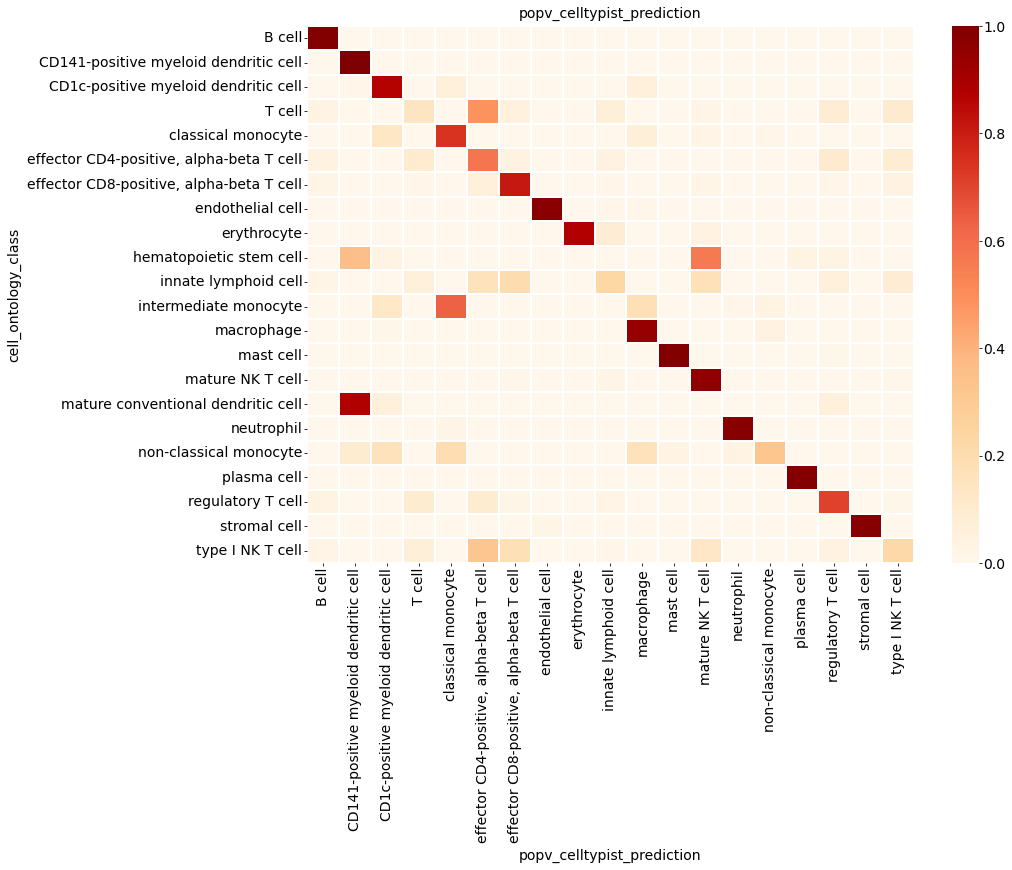

Making confusion matrix for popv_knn_on_bbknn_prediction
maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 42 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 23, 25, 27, 37, 38, 39, 44, 46, 49, 55, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
Closed glyph list over 'GSUB': 47 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'fi', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one'

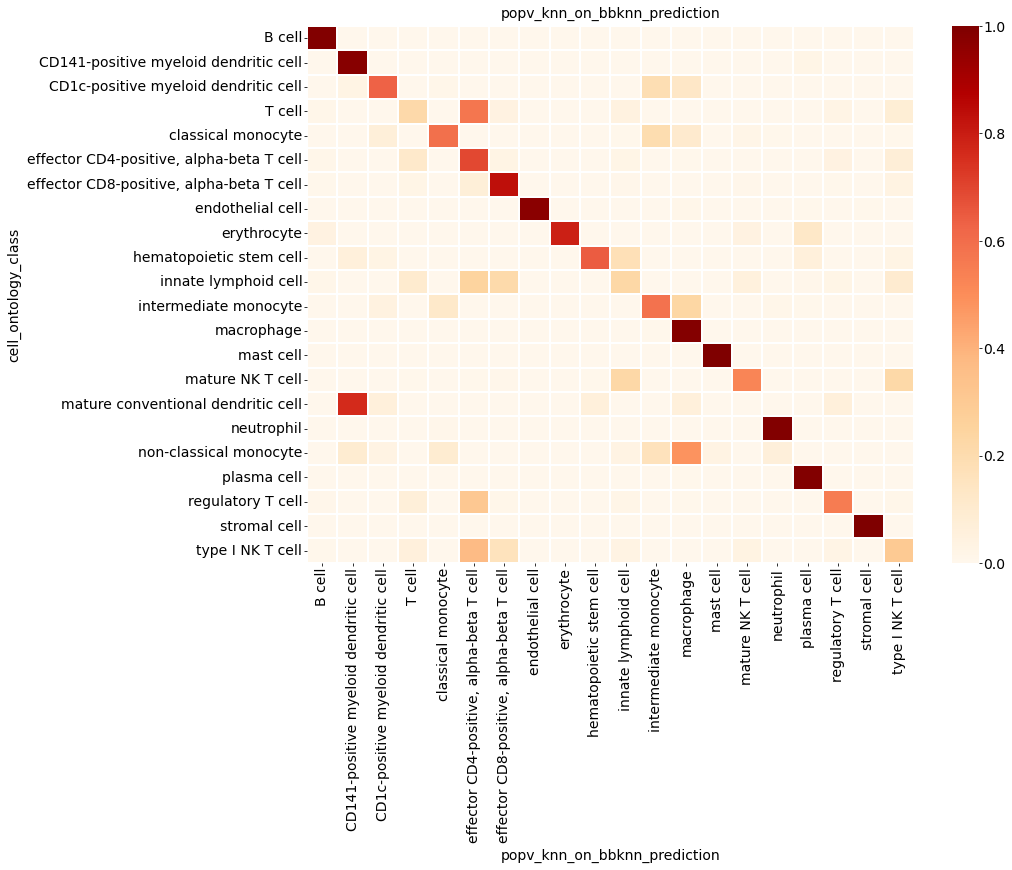

Making confusion matrix for popv_knn_on_scanorama_prediction
maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 42 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 23, 25, 27, 37, 38, 39, 44, 46, 49, 55, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
Closed glyph list over 'GSUB': 47 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'fi', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', '

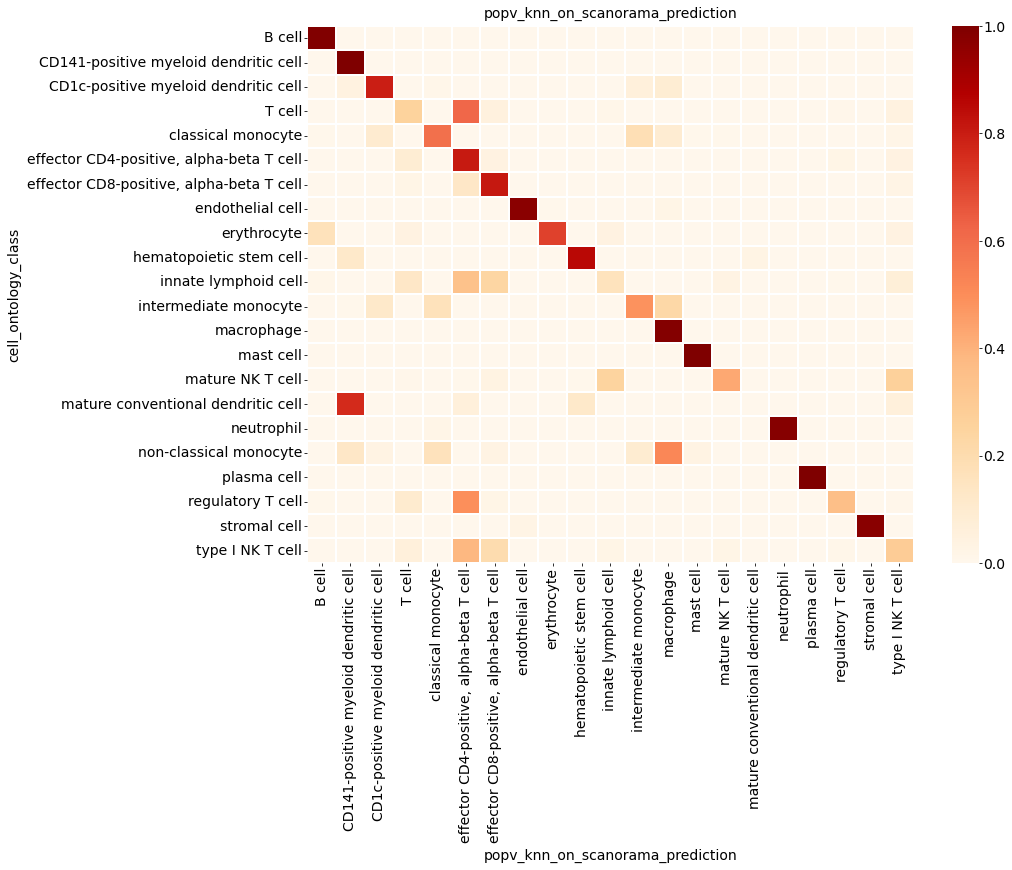

Making confusion matrix for popv_knn_on_scvi_prediction
maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 42 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 23, 25, 27, 37, 38, 39, 44, 46, 49, 55, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
Closed glyph list over 'GSUB': 47 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'fi', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one',

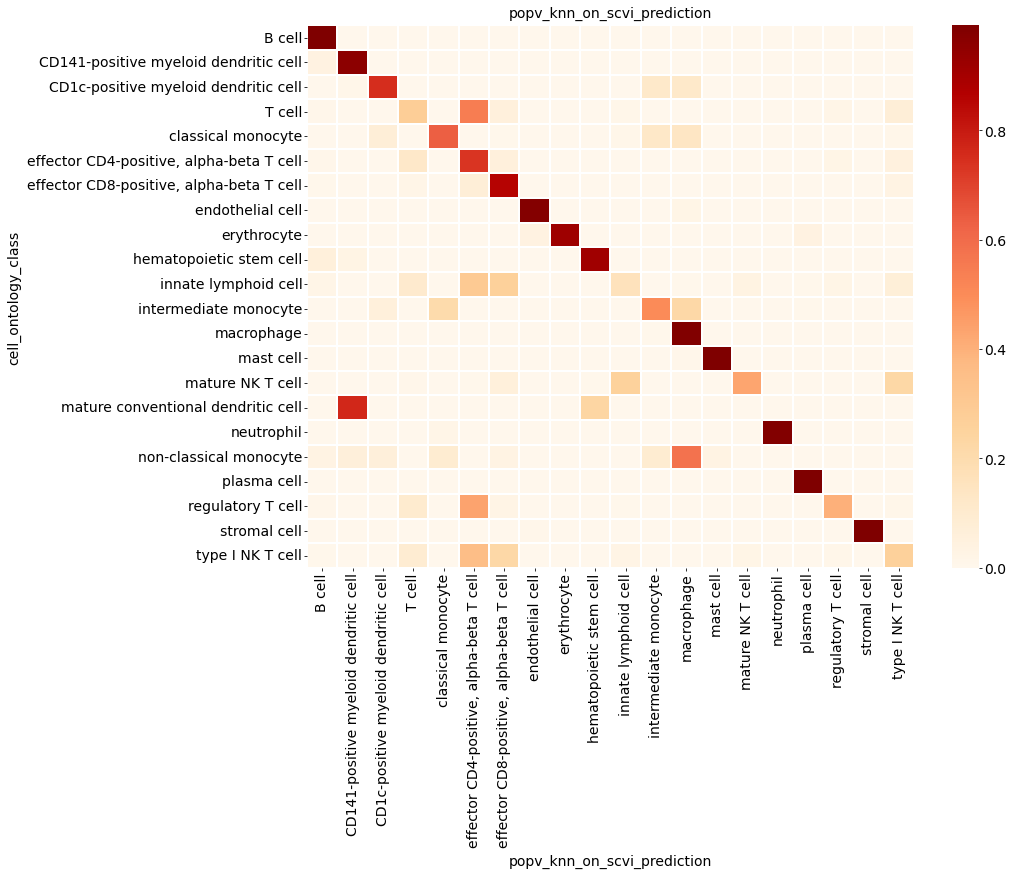

Making confusion matrix for popv_onclass_prediction
maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 41 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 23, 25, 27, 37, 38, 39, 44, 46, 49, 55, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
Closed glyph list over 'GSUB': 46 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'fi', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r

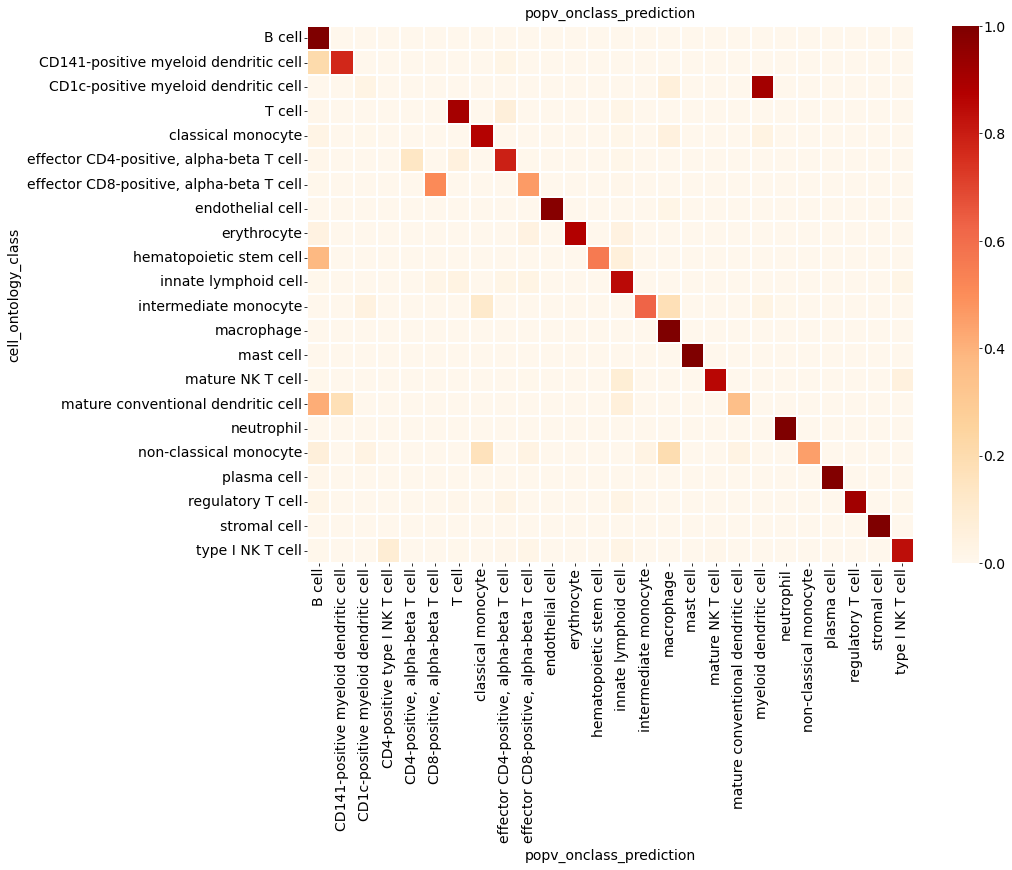

Making confusion matrix for popv_rf_prediction
maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 41 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 23, 25, 27, 37, 38, 39, 44, 46, 49, 55, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
Closed glyph list over 'GSUB': 46 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'fi', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's

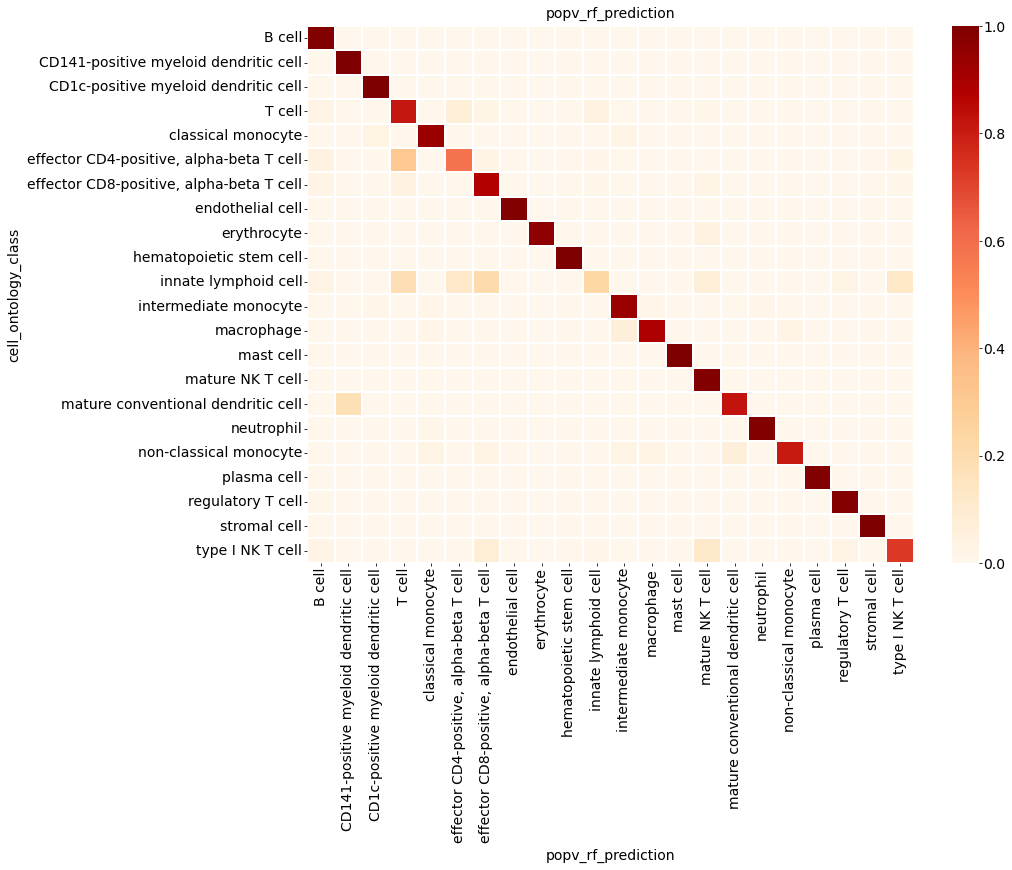

Making confusion matrix for popv_scanvi_prediction
maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 41 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 23, 25, 27, 37, 38, 39, 44, 46, 49, 55, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
Closed glyph list over 'GSUB': 46 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'fi', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r'

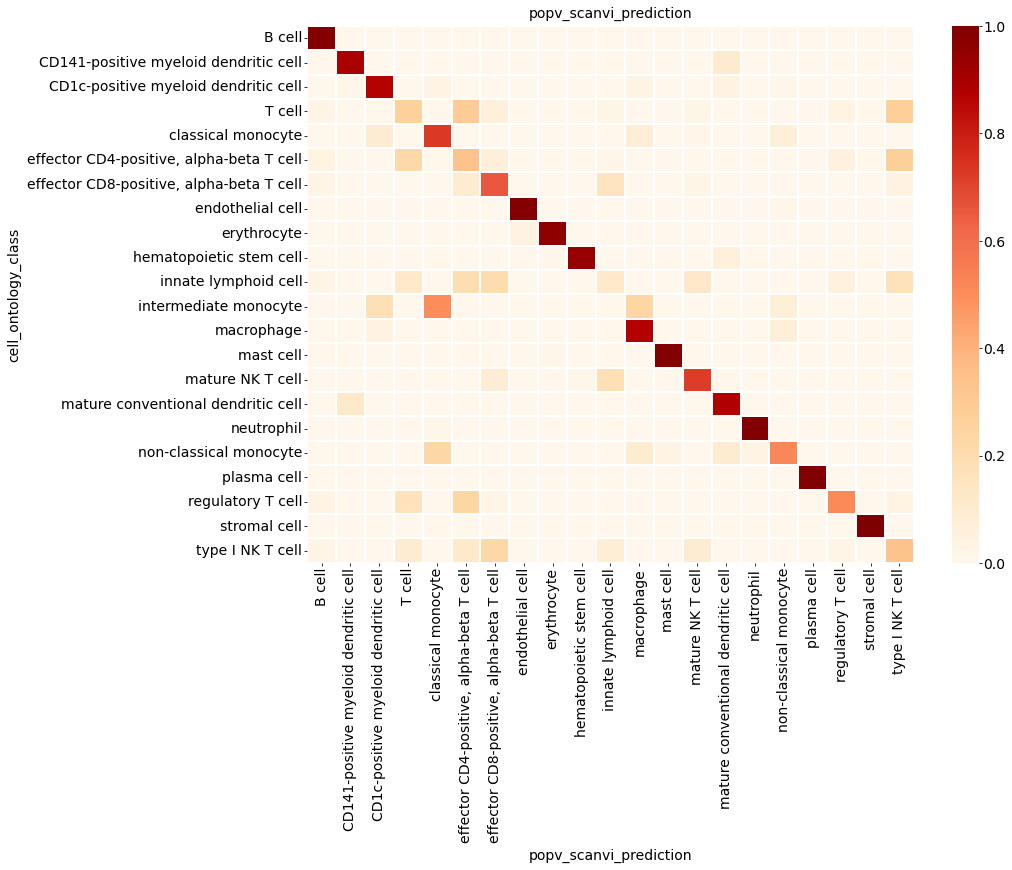

Making confusion matrix for popv_svm_prediction
maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 41 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 23, 25, 27, 37, 38, 39, 44, 46, 49, 55, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
Closed glyph list over 'GSUB': 46 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'fi', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', '

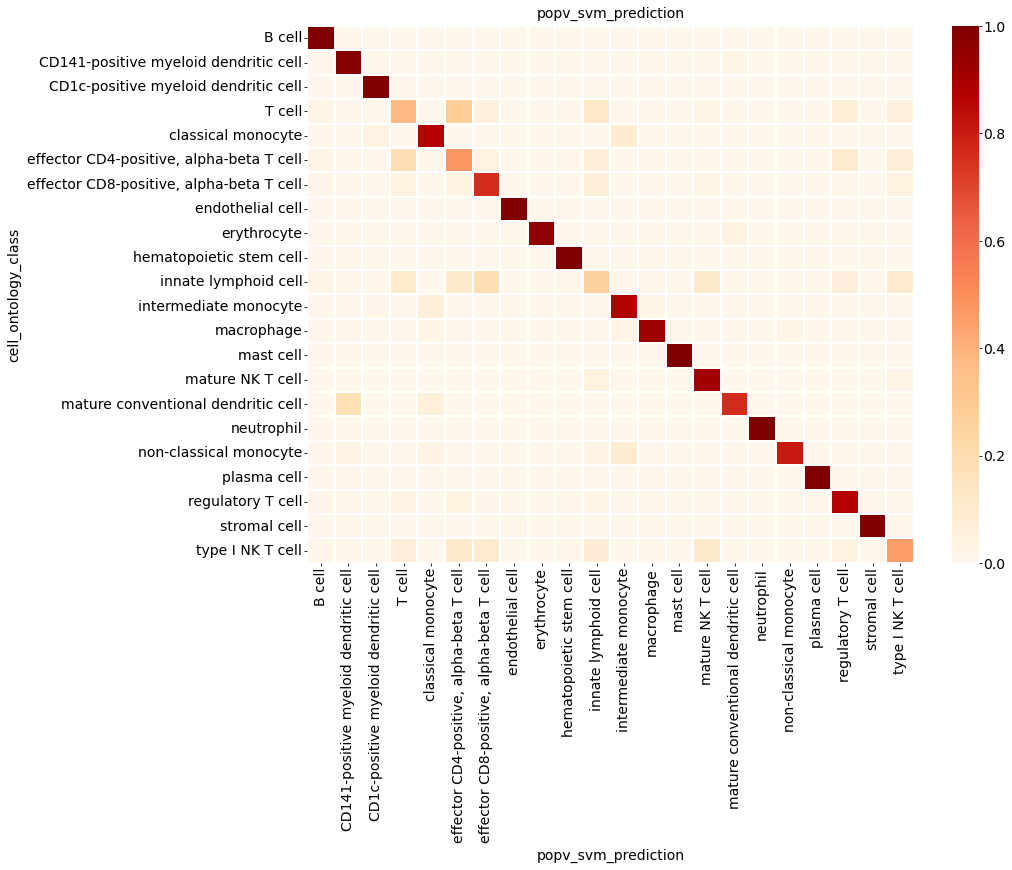

In [17]:
popv.visualization.make_agreement_plots(
    query, prediction_keys=query.uns['prediction_keys'], popv_prediction_key='cell_ontology_class', save_folder='.')

Making confusion matrix for cv_prediction
maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 41 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 23, 25, 27, 37, 38, 39, 44, 46, 49, 55, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
Closed glyph list over 'GSUB': 46 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'fi', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 's

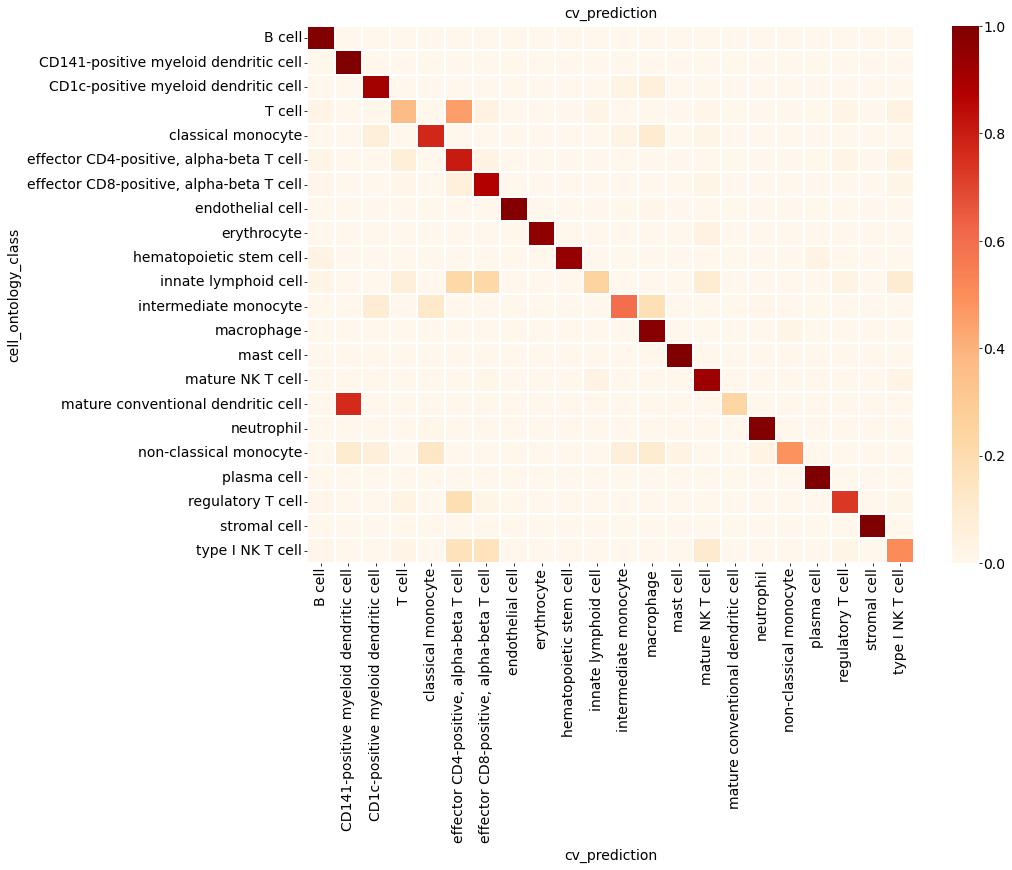

In [18]:
popv.visualization.make_agreement_plots(ln, prediction_keys=['cv_prediction'], popv_prediction_key='cell_ontology_class', save_folder='.')

Making confusion matrix for cv_prediction
maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 41 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 23, 25, 27, 37, 38, 39, 44, 46, 49, 55, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
Closed glyph list over 'GSUB': 46 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'fi', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 's

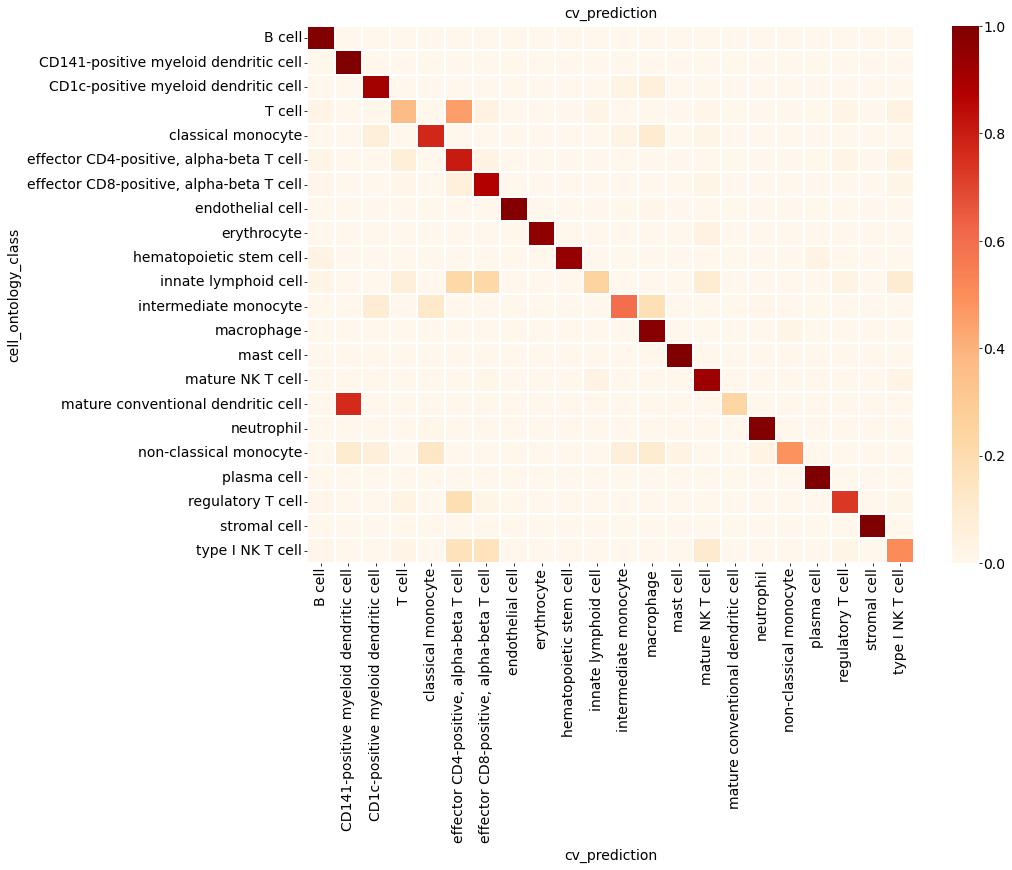

In [19]:
popv.visualization.make_agreement_plots(ln, prediction_keys=['cv_prediction'], popv_prediction_key='cell_ontology_class', save_folder='.')

In [20]:
ln.write('data/ln_cv_results_.h5ad')

... storing 'cv_prediction' as categorical
... storing 'popv_celltypist_prediction' as categorical
... storing 'popv_knn_on_bbknn_prediction' as categorical
... storing 'popv_knn_on_scanorama_prediction' as categorical
... storing 'popv_knn_on_scvi_prediction' as categorical
... storing 'popv_onclass_prediction' as categorical
... storing 'popv_rf_prediction' as categorical
... storing 'popv_scanvi_prediction' as categorical
... storing 'popv_svm_prediction' as categorical
... storing 'popv_prediction_depth' as categorical
... storing 'popv_prediction_onclass_relative_depth' as categorical
... storing 'cv_idx' as categorical
... storing 'cv_prediction_score' as categorical


## Weight matrix

In [21]:
from popv.reproducibility import _accuracy
import pandas as pd

In [22]:
ln = sc.read('data/ln_cv_results_.h5ad')

In [23]:
i = 0
query = anndata.read('cv_run_{}/annotated_query.h5ad'.format(i))
pred_keys = query.uns['prediction_keys']

In [91]:
query_sub = query[query.obs['popv_prediction'].isin([
    'B cell', 'effector CD4-positive, alpha-beta T cell',
    'effector CD8-positive, alpha-beta T cell', 'T cell',
    'type I NK T cell', 'plasma cell', 'mature NK T cell',
    'macrophage', 'regulatory T cell', 'innate lymphoid cell'])]

In [92]:
query_sub.obsm['X_umap'] = query_sub.obsm['X_scanvi_umap_popv']

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 44 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'P', 'S', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'y']
Glyph IDs:   [0, 1, 2, 3, 15, 16, 20, 21, 22, 23, 24, 25, 26, 27, 37, 38, 39, 44, 46, 49, 51, 54, 55, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
Closed glyph list over 'GSUB': 49 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'P', 'S', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'fi', 'five', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven

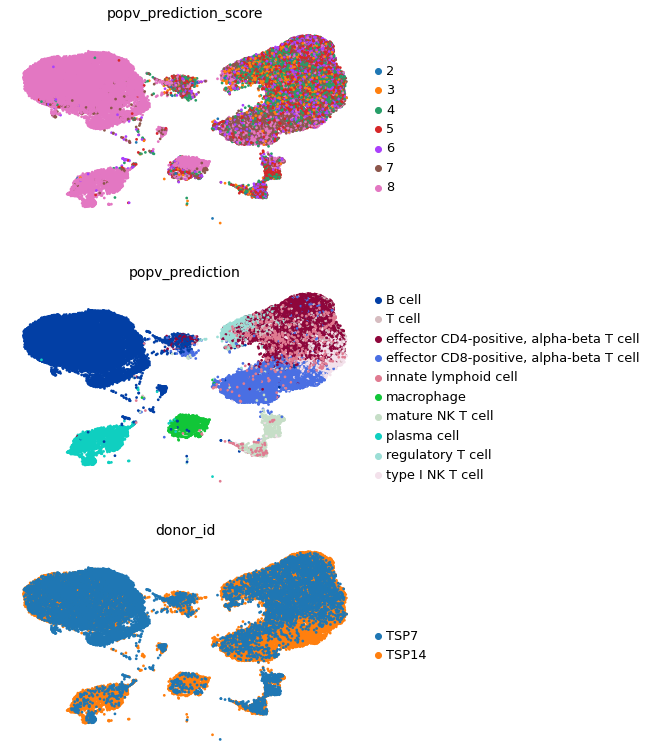

In [93]:
sc.pl.umap(query_sub, color=['popv_prediction_score', 'popv_prediction', 'donor_id'], size=30, ncols=1, save='integrated_metrics')

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 27 glyphs before
Glyph names: ['.notdef', '.null', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'four', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'underscore', 'v', 'zero']
Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 23, 25, 27, 66, 68, 69, 70, 71, 72, 73, 76, 79, 81, 82, 83, 85, 86, 87, 89]
Closed glyph list over 'GSUB': 32 glyphs after
Glyph names: ['.notdef', '.null', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'fi', 'fl', 'four', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'underscore', 'uniFB00', 'uniFB03', 'uniFB04', 'v', 'zero']
Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 23, 25, 27, 66, 68, 69, 70, 71, 72, 73, 76, 79, 81, 82, 83, 85, 86, 87, 89, 5038, 5039, 5040, 5041, 5042]
Closing glyp

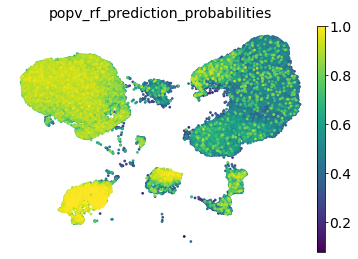

In [94]:
sc.pl.umap(query_sub, color=['popv_rf_prediction_probabilities'], size=30, save='rf_probabilities.pdf')

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 42 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'I', 'K', 'M', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'v', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 21, 23, 24, 26, 27, 36, 37, 38, 39, 44, 46, 48, 49, 55, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
Closed glyph list over 'GSUB': 47 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'I', 'K', 'M', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'fi', 'five', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'two', 

<AxesSubplot:ylabel='Mean Agreement'>

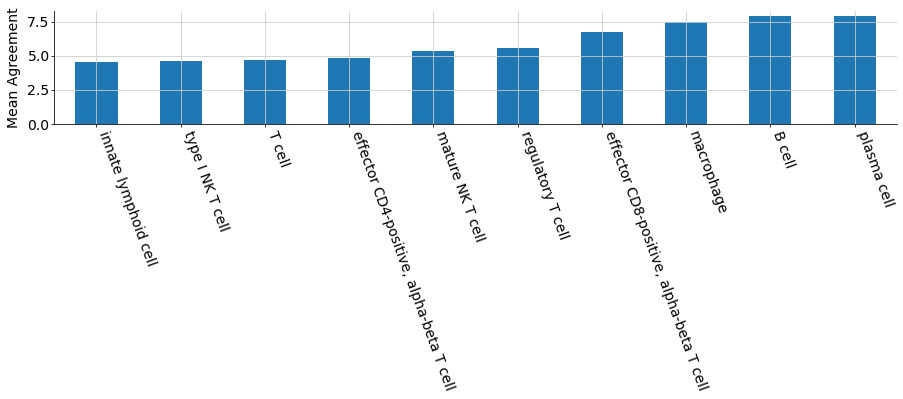

In [102]:
popv.visualization.agreement_score_bar_plot(query_sub, save_folder='figures')

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 41 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'q', 'r', 's', 'space', 't', 'three', 'two', 'u', 'v', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 22, 23, 27, 36, 37, 38, 39, 44, 46, 49, 55, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 92]
Closed glyph list over 'GSUB': 46 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'fi', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'q', 'r', 's', 'space', 't', 'three', 'two', 'u', 'uniFB00', 'uniFB03',

<AxesSubplot:ylabel='log Celltype Abundance'>

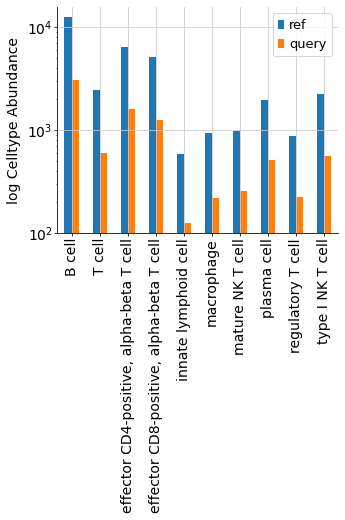

In [96]:
popv.visualization.celltype_ratio_bar_plot(query_sub, save_folder='figures')

Making confusion matrix for popv_rf_prediction
maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 41 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 23, 25, 27, 37, 38, 39, 44, 46, 49, 55, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
Closed glyph list over 'GSUB': 46 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'fi', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's

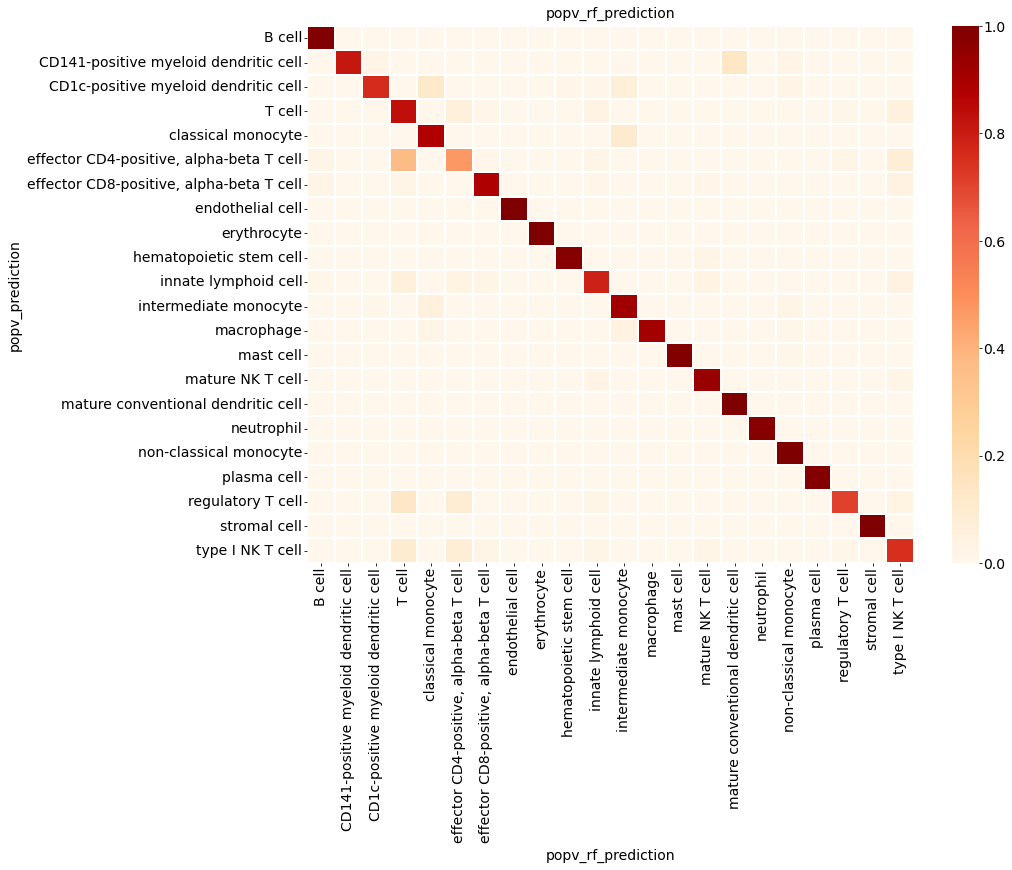

In [98]:
popv.visualization.make_agreement_plots(query, prediction_keys=['popv_rf_prediction'], save_folder='figures')

In [99]:
sc.pp.neighbors(query_sub, use_rep='X_pca')
sc.tl.umap(query_sub)

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 36 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'underscore', 'v', 'y']
Glyph IDs:   [0, 1, 2, 3, 15, 16, 23, 27, 37, 38, 39, 44, 46, 49, 55, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
Closed glyph list over 'GSUB': 41 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'K', 'N', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'fi', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'underscore', 'uniFB00', 'uniFB03', 'uniFB04', 'v', 'y']
Glyph IDs:   [0, 1, 2, 3, 15, 16, 23, 27, 37

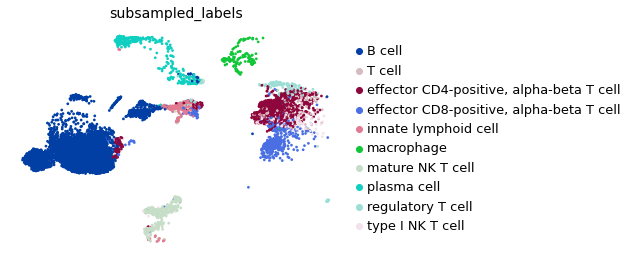

In [100]:
sc.pl.umap(query_sub[query_sub.obs['donor_id']=='TSP7'], color=['subsampled_labels'], size=30, save='annotated_ref.pdf')


maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 16 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'N', 'a', 'b', 'd', 'e', 'l', 'm', 'nonmarkingreturn', 'p', 's', 'space', 'u', 'underscore']
Glyph IDs:   [0, 1, 2, 3, 36, 49, 66, 68, 69, 71, 72, 79, 80, 83, 86, 88]
Closed glyph list over 'GSUB': 16 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'N', 'a', 'b', 'd', 'e', 'l', 'm', 'nonmarkingreturn', 'p', 's', 'space', 'u', 'underscore']
Glyph IDs:   [0, 1, 2, 3, 36, 49, 66, 68, 69, 71, 72, 79, 80, 83, 86, 88]
Closing glyph list over 'MATH': 16 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'N', 'a', 'b', 'd', 'e', 'l', 'm', 'nonmarkingreturn', 'p', 's', 'space', 'u', 'underscore']
Glyph IDs:   [0, 1, 2, 3, 36, 49, 66, 68, 69, 71, 72, 79, 80, 83, 86, 88]
Closed glyph list over 'MATH': 16 glyphs after
Glyph names: ['.notdef', 

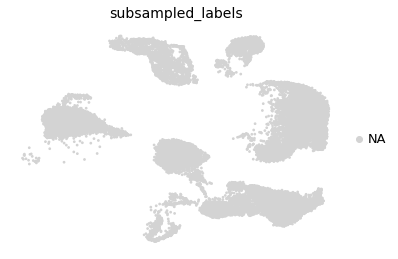

In [101]:
sc.pl.umap(query_sub[query_sub.obs['donor_id']=='TSP14'], color=['subsampled_labels'], size=30, save='unannotated_query')
